## Packages

Let's run the cell below to import all the packages needed.


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Conv2D, BatchNormalization
from tensorflow.keras.activations import linear, relu, sigmoid
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib widget
import matplotlib.pyplot as plt
import CNNutils


### Loading the data

In [11]:
X_train = np.load("savedData/150x150_propVal_aug_balanced/real/x_train.npy")
Y_train = np.load("savedData/150x150_propVal_aug_balanced/real/y_train.npy")
x_val=np.load("savedData/150x150_propVal_aug_balanced/real/x_val.npy") #cross validation data 
y_val=np.load("savedData/150x150_propVal_aug_balanced/real/y_val.npy") #cross validation data 
x_test=np.load("savedData/150x150_propVal_aug_balanced/real/x_test.npy") #test set image
y_test=np.load("savedData/150x150_propVal_aug_balanced/real/y_test.npy") #test set classification


### Visualisation

we can print the shape of each array

In [12]:
print("the shape of X_train is", X_train.shape)
print("the shape of y is", Y_train.shape)
print("x_small shape is", x_val.shape)
print("y_small shape is", y_val.shape)
print("x_test shape is", x_test.shape)
print("y_test shape is ", y_test.shape)

the shape of X_train is (9564, 150, 150, 1)
the shape of y is (9564,)
x_small shape is (1044, 150, 150, 1)
y_small shape is (1044,)
x_test shape is (624, 150, 150, 1)
y_test shape is  (624,)


we can print the first element of each array

the first element of X is [[[0.21568628]
  [0.23109421]
  [0.2467206 ]
  ...
  [0.3724112 ]
  [0.36029056]
  [0.35689005]]

 [[0.21568628]
  [0.21568628]
  [0.21951668]
  ...
  [0.364598  ]
  [0.35833725]
  [0.3453068 ]]

 [[0.19824599]
  [0.20996577]
  [0.21568628]
  ...
  [0.35978445]
  [0.35398996]
  [0.33358702]]

 ...

 [[0.73333335]
  [0.73333335]
  [0.73333335]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.73333335]
  [0.73333335]
  [0.73142654]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.73333335]
  [0.73333335]
  [0.7275199 ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]
The first element of y is 1


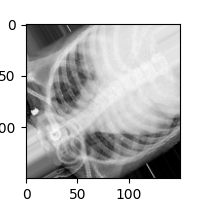

(150, 150)


In [13]:
print("the first element of X is", X_train[0])
print("The first element of y is",Y_train[0])
inputShape=np.squeeze(X_train[0],axis=-1).shape
CNNutils.display_xRAY(X_train[0],inputShape)
print(inputShape)

## Convolutional Neural Network

we can now implement our CNN model

In [14]:
#code assignment starts here
tf.random.set_seed(1234)  # applied to achieve consistent results

CNN_model = Sequential((
    [
        (Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = X_train[0].shape)),
        (BatchNormalization()),
        (MaxPool2D((2,2) , strides = 2 , padding = 'same')),
        
        (Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (BatchNormalization()),
        (MaxPool2D((2,2) , strides = 2 , padding = 'same')),
        (Dropout(0.2)),

        (Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (BatchNormalization()),
        (MaxPool2D((2,2) , strides = 2 , padding = 'same')),
        
        (Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (BatchNormalization()),
        (MaxPool2D((2,2) , strides = 2 , padding = 'same')),
        (Dropout(0.2)),
        
        (Flatten()),
        
        (Dense(units = 64 , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (Dropout(0.2)),
        
        (Dense(units = 32 , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (Dropout(0.1)),
        
        (Dense(units = 3 , activation = 'linear')) 
    ]
),name='CNN')

CNN_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #prefered way of implementing a softmax
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

#code assignment stops here

we can check our model's detail

In [15]:
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_9 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                               

We use a a function that stop when the val encounter a plateau in order to avoid overfittin

In [16]:
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Testing

we can then fit our model and our data


In [17]:
#code from the assignment start here:
history = CNN_model.fit(
    X_train,Y_train,
    epochs=50,
    validation_data = (x_val, y_val),
    callbacks= [early_stopping,Reduce_LR],
)

#end of the code from assignment

Epoch 1/50
299/299 [==============================] - 189s 620ms/step - loss: 8.3733 - accuracy: 0.5806 - val_loss: 3.0261 - val_accuracy: 0.2711 - lr: 0.0010
Epoch 2/50
299/299 [==============================] - 192s 643ms/step - loss: 1.5604 - accuracy: 0.6308 - val_loss: 1.8726 - val_accuracy: 0.2433 - lr: 0.0010
Epoch 3/50
299/299 [==============================] - 162s 542ms/step - loss: 1.1977 - accuracy: 0.6539 - val_loss: 2.9377 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 4/50
299/299 [==============================] - 199s 666ms/step - loss: 1.0569 - accuracy: 0.6789 - val_loss: 1.2960 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 5/50
299/299 [==============================] - 213s 712ms/step - loss: 1.0022 - accuracy: 0.6924 - val_loss: 1.6421 - val_accuracy: 0.5297 - lr: 0.0010
Epoch 6/50
299/299 [==============================] - 208s 696ms/step - loss: 0.9845 - accuracy: 0.6927 - val_loss: 3.4106 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 7/50
299/299 [==========================

### Metrics on train set

We can observe the metrics of the model

In [18]:
# Prediction on our training data
y_pred_train = CNN_model.predict(X_train)

#beginning of code from the assignment for softmax uses
prediction_p = tf.nn.softmax(y_pred_train)
y_pred_classes = np.argmax(prediction_p, axis=1)
#enf od code from assignment



In [19]:
print(classification_report(Y_train, y_pred_classes,zero_division=1, target_names = ['Normal (Class 0)','Bacteria (Class 1)','Viral (class 2)']))
print("Loss of the model is - " , CNN_model.evaluate(X_train,Y_train)[0])
print("Accuracy of the model is - " , CNN_model.evaluate(X_train,Y_train)[1]*100 , "%")

                    precision    recall  f1-score   support

  Normal (Class 0)       1.00      0.85      0.92      3168
Bacteria (Class 1)       0.72      0.69      0.71      3198
   Viral (class 2)       0.62      0.73      0.67      3198

          accuracy                           0.76      9564
         macro avg       0.78      0.76      0.77      9564
      weighted avg       0.78      0.76      0.77      9564

299/299 [==============================] - 44s 139ms/step - loss: 0.6018 - accuracy: 0.7591
Loss of the model is -  0.6018435955047607
299/299 [==============================] - 45s 143ms/step - loss: 0.6018 - accuracy: 0.7591
Accuracy of the model is -  75.9096622467041 %


#### overfitting
We can plot the training accuracy and the validation accuracy to have a first idea of the overfitting of our model. If the Validation accuracy stops or decrease and the training one is increasing that might indicate case of overfitting the training set.
If the validation loss keep increasing and the training one keep decreasing that might suggest overfitting

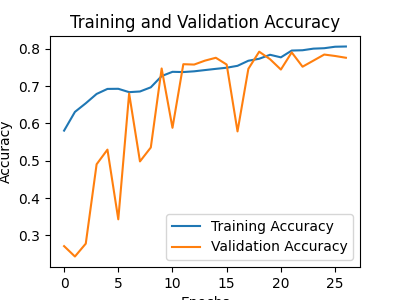

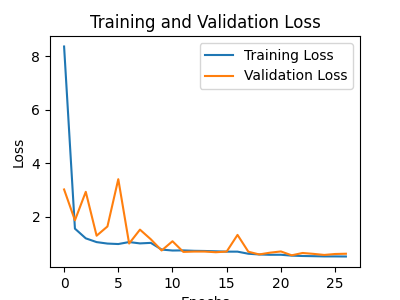

In [20]:
CNNutils.plt_Training_Val_Accuracy(history)
CNNutils.plt_Training_Val_loss(history)

### Prediction
we can now try our model on the test set


In [21]:
#prediction on the test set
y_pred_test=CNN_model.predict(x_test)

#beginning of code from the assignment for softmax uses
prediction = tf.nn.softmax(y_pred_test)
prediction_classes = np.argmax(prediction, axis=1)
#enf od code from assignment

#print partly of the result
print("the first ten classes are :", prediction_classes[:10])

the first ten classes are : [1 0 1 1 0 0 0 0 1 1]


### Analysis of the prediction

we can calculate the metrics of our prediction of the test set this time to have even more information of our model

                    precision    recall  f1-score   support

  Normal (Class 0)       0.96      0.46      0.62       234
Bacteria (Class 1)       0.82      0.86      0.84       242
   Viral (class 2)       0.49      0.85      0.62       148

          accuracy                           0.71       624
         macro avg       0.76      0.72      0.69       624
      weighted avg       0.79      0.71      0.71       624

20/20 [==============================] - 4s 148ms/step - loss: 0.9754 - accuracy: 0.7083
Loss of the model is -  0.975418746471405
20/20 [==============================] - 4s 141ms/step - loss: 0.9754 - accuracy: 0.7083
Accuracy of the model is -  70.83333134651184 %


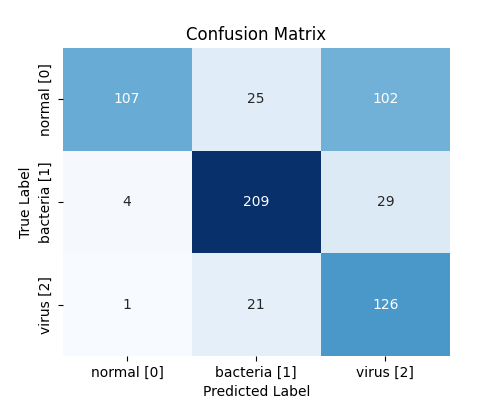

In [23]:
print(classification_report(y_test, prediction_classes,zero_division=1, target_names = ['Normal (Class 0)','Bacteria (Class 1)','Viral (class 2)']))
print("Loss of the model is - " , CNN_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , CNN_model.evaluate(x_test,y_test)[1]*100 , "%")

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, prediction_classes)
CNNutils.plt_conf_matrix(conf_matrix)


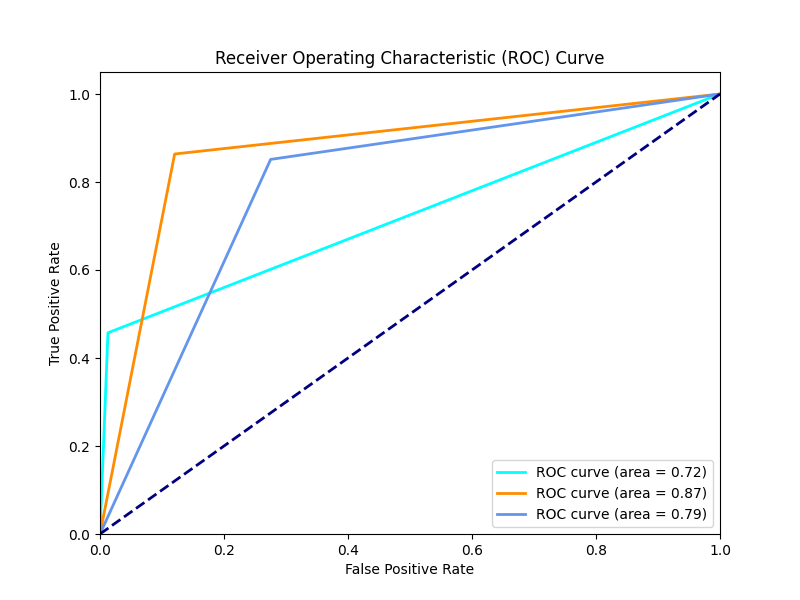

In [24]:
CNNutils.plot_roc_curve(y_test, prediction_classes, 3)